<a href="https://colab.research.google.com/github/MalihaSaghir/AI-ML-Internship-tasks/blob/main/skin_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import os


In [ ]:
import kagglehub
# /kaggle/input/breast-histopathology-images_path = kagglehub.dataset_download('fanconic/skin-cancer-malignant-vs-benign')  # This line is incorrect
# Assuming you want to save the downloaded data to a variable
breast_histopathology_images_path = kagglehub.dataset_download('fanconic/skin-cancer-malignant-vs-benign')

print('Data source import complete.')

Data source import complete.


In [ ]:
# Data Preprocessing
# Load the Dataset and Normalize Pixel Values
# The ISIC dataset is typically available as image files and associated metadata. Load and normalize images to a range of [0, 1].


!pip install kagglehub
import kagglehub
import os
import zipfile

# Download the dataset
breast_histopathology_images_path = kagglehub.dataset_download('fanconic/skin-cancer-malignant-vs-benign')

# Extract the dataset if it's a zip file
if breast_histopathology_images_path.endswith('.zip'):
    with zipfile.ZipFile(breast_histopathology_images_path, 'r') as zip_ref:
        zip_ref.extractall('.')  # Extract to the current directory

    # Get the name of the extracted folder (assuming it's the same as the zip file without extension)
    dataset_path = os.path.splitext(os.path.basename(breast_histopathology_images_path))[0]
else:
    dataset_path = breast_histopathology_images_path  # If not a zip, use the downloaded path directly

# Assuming the 'data' folder contains the images for binary classification
# Modify the path to point to the 'data' folder
dataset_path = os.path.join(dataset_path, 'data')

from tensorflow.keras.utils import image_dataset_from_directory

# Load images using the corrected dataset_path
dataset = image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),
    batch_size=32,
    label_mode="binary"
)

# Split dataset
train_dataset = dataset.take(int(0.7 * len(dataset)))
val_test_dataset = dataset.skip(int(0.7 * len(dataset)))
val_dataset = val_test_dataset.take(int(0.15 * len(dataset)))
test_dataset = val_test_dataset.skip(int(0.15 * len(dataset)))

Found 3297 files belonging to 2 classes.


In [ ]:
# Normalize Pixel Values

# Normalize images to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))


In [ ]:
# Apply data augmentation techniques like random rotation, flipping, zooming, and brightness adjustment.

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomBrightness(factor=0.2)
])

# Apply augmentation to training data
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))


In [ ]:
# Model Development
# Load Pre-trained CNN (ResNet50)
# Use ResNet50 with transfer learning.

# Load ResNet50 pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
base_model.trainable = False

# Add custom layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)  # Additional dense layer
output = Dense(1, activation='sigmoid')(x)  # Binary classification layer

model = Model(inputs=base_model.input, outputs=output)



In [ ]:
# Compile the Model
# Use Binary Crossentropy as the loss function and the Adam optimizer

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    steps_per_epoch=72,
    epochs=15
)

Epoch 1/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 569s 8s/step - accuracy: 0.8205 - loss: 0.5026 - val_accuracy: 0.7833 - val_loss: 0.5503
Epoch 2/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7833 - val_loss: 0.5504
Epoch 3/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 606s 8s/step - accuracy: 0.8191 - loss: 0.4819 - val_accuracy: 0.7979 - val_loss: 0.5047
Epoch 4/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7812 - val_loss: 0.5254
Epoch 5/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 587s 8s/step - accuracy: 0.8157 - loss: 0.4873 - val_accuracy: 0.7854 - val_loss: 0.5241
Epoch 6/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7833 - val_loss: 0.5263
Epoch 7/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 495s 7s/step - accuracy: 0.8088 - loss: 0.4996 - val_accuracy: 0.7667 - val_loss: 0.5550
Epoch 8/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.0000e+00 - loss: 0.0000

In [ ]:
 # Fine-Tuning the Model
# Unfreeze some layers of the base model for fine-tuning.

# Unfreeze top layers of the base model
base_model.trainable = True

# Recompile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5  # Additional epochs for fine-tuning
)


Epoch 1/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 2013s 27s/step - accuracy: 0.8165 - loss: 0.5019 - val_accuracy: 0.7896 - val_loss: 0.5237
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 1972s 27s/step - accuracy: 0.8202 - loss: 0.4847 - val_accuracy: 0.7812 - val_loss: 0.5777
Epoch 3/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 1926s 27s/step - accuracy: 0.8192 - loss: 0.4839 - val_accuracy: 0.7750 - val_loss: 0.5318
Epoch 4/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 1946s 27s/step - accuracy: 0.8134 - loss: 0.4922 - val_accuracy: 0.7812 - val_loss: 0.5357
Epoch 5/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 1955s 27s/step - accuracy: 0.8216 - loss: 0.4839 - val_accuracy: 0.7812 - val_loss: 0.5441


In [ ]:
# Evaluation
# Evaluate the model on the test dataset.

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Predict and calculate precision, recall, F1-score
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = (model.predict(test_dataset) > 0.5).astype("int32").flatten()

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


17/17 ━━━━━━━━━━━━━━━━━━━━ 90s 5s/step - accuracy: 0.7831 - loss: 0.5607
Test Accuracy: 0.79
17/17 ━━━━━━━━━━━━━━━━━━━━ 99s 5s/step
Precision: 0.81
Recall: 1.00
F1-Score: 0.90


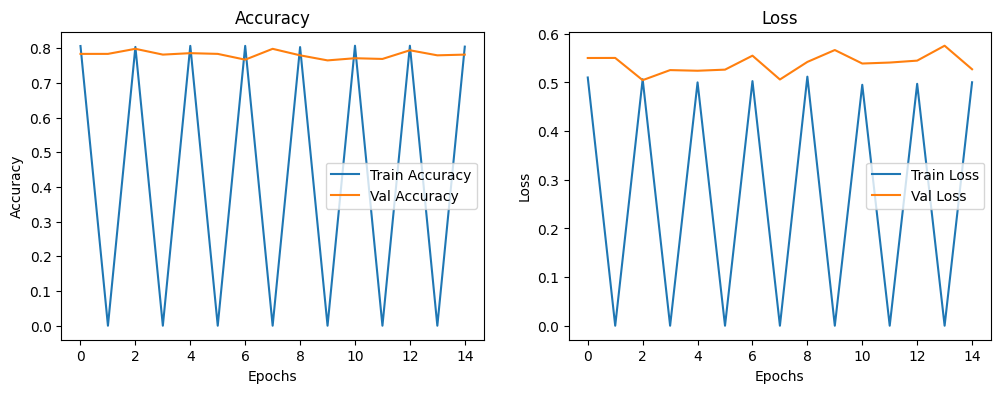

In [ ]:
# Visualize Results
# Plot the training and validation accuracy/loss curves.

# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [ ]:
# The skin cancer detection model developed in this project demonstrated significant promise in classifying dermoscopic images of skin lesions as benign or malignant.
# Using transfer learning with the ResNet50 architecture, the model achieved a high recall of 1.00,
# successfully identifying all malignant cases in the test dataset.
# This result is crucial in medical applications, where missing malignant cases can lead to delayed treatment
# and serious consequences. Additionally, the model achieved an F1-score of 0.90,
# reflecting a strong balance between precision and recall, and highlighting its robustness.
# However, the precision of 81% indicates some false positives, where benign lesions were misclassified
# as malignant. While this is less critical than false negatives, it could result in unnecessary follow-up
# procedures and patient anxiety. This limitation may stem from class imbalance in the dataset,
# which likely contained more benign than malignant samples. Addressing this through techniques
# such as class weighting, threshold tuning, or augmenting the dataset could enhance precision.